In [1]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

np.random.seed(2018)

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kangting/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
#change
documents = pd.read_csv('after translate - android_23 march.csv')

In [45]:
documents

,review,rating,Country,Translated
0,Seems good in service ❤️I wish I can shop onli...,4,en,Seems good in service ❤️I wish I can shop onli...
1,Kalian ada yg tau g kenapa gua cuman kasih bin...,1,id,Someone you know why cave cuman g love 1 becau...
2,OK,5,id,OK
3,App is not working. I tired to reinstall it bu...,1,en,App is not working. I tired to reinstall it bu...
4,Good,5,id,Good
...,...,...,...,...
448,Keren,5,id,Keren
449,Mantap abis,5,id,steady abis
450,ZALORA PALING TOP!!!! TENGKIYU,5,id,ZALORA MOST TOP !!!! TENGKIYU
451,Tolong zalora terima masukkan pembeli untuk ja...,1,id,Please zalora thank enter the buyer's do not u...


In [46]:
df_new = documents

,review,rating,Country,Translated
0,Seems good in service ❤️I wish I can shop onli...,4,en,Seems good in service ❤️I wish I can shop onli...
1,Kalian ada yg tau g kenapa gua cuman kasih bin...,1,id,Someone you know why cave cuman g love 1 becau...
2,OK,5,id,OK
3,App is not working. I tired to reinstall it bu...,1,en,App is not working. I tired to reinstall it bu...
4,Good,5,id,Good


In [47]:
low_star = df_new[(df_new["rating"] == 1) | (df_new["rating"] == 2) | (df_new["rating"] == 3)].reset_index().drop(['index'], axis=1)

In [48]:
#low_star = df_new[(df_new["rating"] == 1) | (df_new["rating"] == 2) | (df_new["rating"] == 3)].reset_index().drop(['index','Unnamed: 0'], axis=1)

In [49]:
#low_star = df_new[(df_new["rating"] == 'Detractor')| (df_new["rating"] == 'Passive')].reset_index().drop(['index'], axis=1)
low_star.count()
low_star.head()

,review,rating,Country,Translated
0,Kalian ada yg tau g kenapa gua cuman kasih bin...,1,id,Someone you know why cave cuman g love 1 becau...
1,App is not working. I tired to reinstall it bu...,1,en,App is not working. I tired to reinstall it bu...
2,Sebenarnya zalora bagus tapi sayangnya tak ada...,1,id,Zalora actually nice but unfortunately there i...
3,Brand yang saya mengikuti kenapa selalu di hap...,1,id,Brand I follow why always in the clear in my B...
4,Products are of real quality... but lately it ...,3,en,Products are of real quality... but lately it ...


In [50]:
#low_star = df_new
low_star.columns =["Old review","rating","country","Review Text"] 
low_star

,Old review,rating,country,Review Text
0,Kalian ada yg tau g kenapa gua cuman kasih bin...,1,id,Someone you know why cave cuman g love 1 becau...
1,App is not working. I tired to reinstall it bu...,1,en,App is not working. I tired to reinstall it bu...
2,Sebenarnya zalora bagus tapi sayangnya tak ada...,1,id,Zalora actually nice but unfortunately there i...
3,Brand yang saya mengikuti kenapa selalu di hap...,1,id,Brand I follow why always in the clear in my B...
4,Products are of real quality... but lately it ...,3,en,Products are of real quality... but lately it ...
...,...,...,...,...
81,"I love the live chat agent system, but it stil...",1,en,"I love the live chat agent system, but it stil..."
82,Barangnya lama kali sampe kak,3,id,Goods long time until kak
83,Kok kota aku ga ada kak? :( Jadi gimana mau or...,1,id,Kok town I ga kak? :( So how you want to order?
84,Tolong zalora terima masukkan pembeli untuk ja...,1,id,Please zalora thank enter the buyer's do not u...


## Data Pre-processing


We will perform the following steps:

1) Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

2) Words that have fewer than 3 characters are removed.

3) All stopwords are removed. Some words like 'zalora', 'shop', 'item' and 'unit' featured as important words in some of the topics, but these words don't add alot of meaning in intepreting the problem, so these are added to the stopwords

5) Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.

6) Words are stemmed — words are reduced to their root form.

In [51]:
low_star['Review Text']

0     Someone you know why cave cuman g love 1 becau...
1     App is not working. I tired to reinstall it bu...
2     Zalora actually nice but unfortunately there i...
3     Brand I follow why always in the clear in my B...
4     Products are of real quality... but lately it ...
                            ...                        
81    I love the live chat agent system, but it stil...
82                            Goods long time until kak
83      Kok town I ga kak? :( So how you want to order?
84    Please zalora thank enter the buyer's do not u...
85    Bad!. Pbyrn system ga ga simple clear language...
Name: Review Text, Length: 86, dtype: object

In [52]:
low_star['Review Text'][0]

'Someone you know why cave cuman g love 1 because when I wrote a bag that appears even justice shirts justice, weird right'

In [53]:
low_star = low_star.dropna()

In [54]:
low_star.count()

Old review     86
rating         86
country        86
Review Text    86
dtype: int64

In [55]:
stemmer = SnowballStemmer('english')
stop_words = gensim.parsing.preprocessing.STOPWORDS.union(set(['zalora','item','order','shop','shopping','veri','applic','shoe','product','want','realli','good']))

def lemmatize_stemming(text):
    #return WordNetLemmatizer().lemmatize(text, pos='v')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        token = lemmatize_stemming(token)
        if token not in stop_words and len(token) > 3:
            result.append(token)
    return result


In [56]:
doc_sample = low_star['Review Text'][50]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['They', 'will', 'deliver', 'the', 'lowest', 'quality', 'available.']


 tokenized and lemmatized document: 
['deliv', 'lowest', 'qualiti', 'avail']


In [57]:
low_star['Review Text'].map(preprocess)

0     [someon, know, cave, cuman, love, becaus, writ...
1                 [work, tire, reinstal, thing, happen]
2     [actual, nice, unfortun, payment, alfamart, in...
3     [brand, follow, alway, clear, branda, alway, n...
4     [real, qualiti, late, crash, uninstal, instal,...
                            ...                        
81    [love, live, chat, agent, problem, messag, sen...
82                                         [long, time]
83                                               [town]
84    [pleas, thank, enter, buyer, servic, send, exp...
85    [pbyrn, simpl, clear, languag, confus, account...
Name: Review Text, Length: 86, dtype: object

In [58]:
processed_docs = low_star['Review Text'].map(preprocess)
processed_docs[:10]

0    [someon, know, cave, cuman, love, becaus, writ...
1                [work, tire, reinstal, thing, happen]
2    [actual, nice, unfortun, payment, alfamart, in...
3    [brand, follow, alway, clear, branda, alway, n...
4    [real, qualiti, late, crash, uninstal, instal,...
5                                        [crash, vivo]
6    [deliveri, time, alesan, overload, pack, batal...
7                                   [incomplet, updat]
8                                               [help]
9                                [review, avail, suck]
Name: Review Text, dtype: object

In [59]:
processed_docs = [' '.join(x) for x in processed_docs]

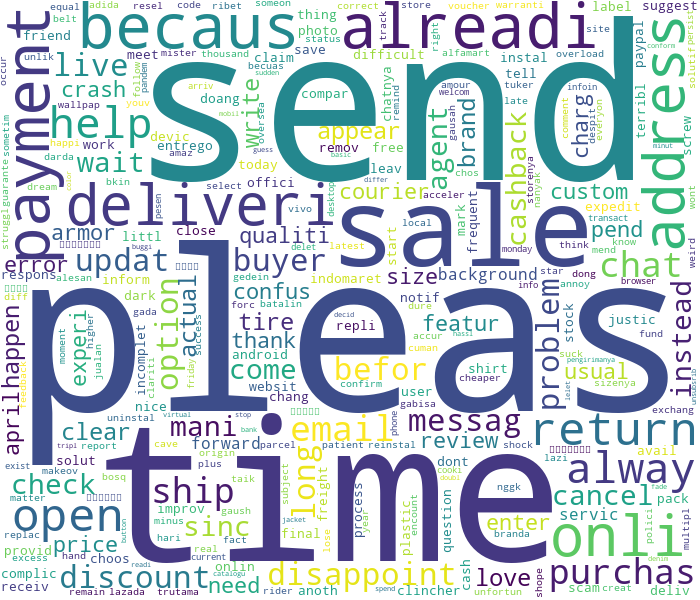

In [60]:
# Join the different processed titles together.

long_string = ','.join(processed_docs)

# Create a WordCloud object

wordcloud = WordCloud(background_color="white", max_words=300, width=700, height = 600, contour_color='steelblue')
# Generate a word cloud

wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [61]:
long_string = long_string.replace(',', ' ')

In [62]:
#export to CSV
df_fullwords = pd.DataFrame(long_string.split(' '))
df_fullwords.to_csv('full_words.csv')

In [63]:
df_fullwords

,0
0,someon
1,know
2,cave
3,cuman
4,love
...,...
753,check
754,profit
755,come
756,quieter


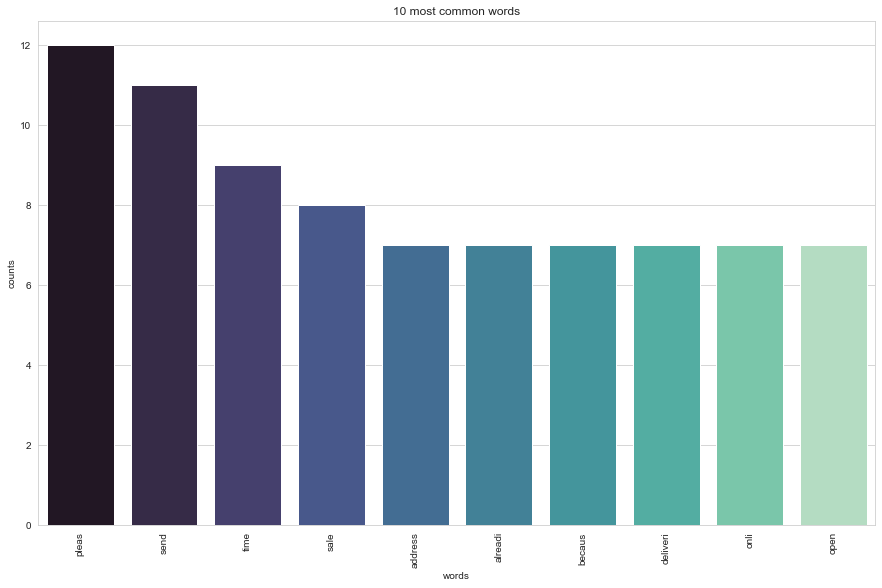

In [64]:
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts , palette='mako') #, palette='husl'
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(processed_docs)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [65]:
# Tweak the two parameters below
number_topics = 4
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(n_components=4, n_jobs=-1)

In [66]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(topic.argsort()[:-n_top_words - 1:-1])
        
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #1:
pleas return time buyer onli wait forward armor purchas option

Topic #2:
deliveri send address disappoint long time instead charg price alway

Topic #3:
sale live chat agent pleas sinc messag qualiti crash befor

Topic #4:
open payment alreadi ship updat help mani purchas courier background


In [67]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

In [68]:
pyLDAvis.display(LDAvis_prepared)

# GridSearch

We now perform hyperparatmer tuning across 2 parameters: the number of components, and the learning decay

We gridsearch across 10 number of topics and 3 learning decays, and select the best model based on the higest log likelihood score, which is a statistical measure of goodness of fit.

In [69]:
%%time

search_params = {'n_components': [x+1 for x in range(3,10)], 'learning_decay': [.5, .7, .9]}

lda = LDA()

model = GridSearchCV(lda, param_grid=search_params)

model.fit(count_data)

CPU times: user 8.44 s, sys: 33.7 ms, total: 8.47 s
Wall time: 8.58 s


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [4, 5, 6, 7, 8, 9, 10]})

In [70]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(count_data))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
Best Log Likelihood Score:  -1698.7434021305078
Model Perplexity:  662.0170806155822


In [71]:
print("Topics found via LDA:")
print_topics(best_lda_model, count_vectorizer, number_words)

Topics found via LDA:

Topic #1:
send pleas buyer live time sale becaus chat deliveri forward

Topic #2:
payment email open alway discount time wait clear error review

Topic #3:
return problem onli cashback address becaus sinc courier armor chat

Topic #4:
pleas long sale deliveri mani background april address messag photo


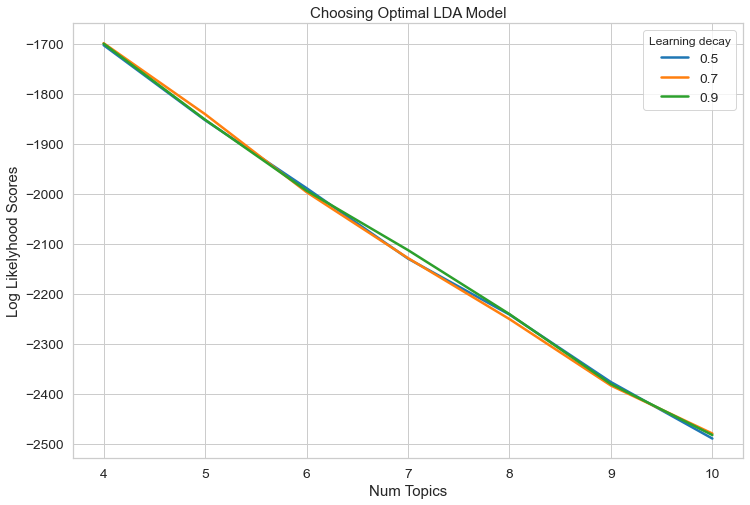

In [72]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [x+1 for x in range(3,10)]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][y]) for y in [model.cv_results_['params'].index(x) 
                                                                       for x in model.cv_results_['params'] if x['learning_decay']==0.5]]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][y]) for y in [model.cv_results_['params'].index(x) 
                                                                       for x in model.cv_results_['params'] if x['learning_decay']==0.7]]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][y]) for y in [model.cv_results_['params'].index(x) 
                                                                       for x in model.cv_results_['params'] if x['learning_decay']==0.9]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [73]:
lda_output = best_lda_model.transform(count_data)

In [74]:
lda_output

array([[0.01795091, 0.0179961 , 0.94598545, 0.01806755],
       [0.0428982 , 0.87266768, 0.04170212, 0.042732  ],
       [0.02098333, 0.93701198, 0.02100901, 0.02099569],
       [0.01687739, 0.949638  , 0.016751  , 0.0167336 ],
       [0.91205597, 0.03203125, 0.02780714, 0.02810564],
       [0.08459758, 0.74857345, 0.08340407, 0.0834249 ],
       [0.01272139, 0.96189502, 0.01258739, 0.0127962 ],
       [0.08576133, 0.09068068, 0.09029083, 0.73326716],
       [0.12780139, 0.61433415, 0.13280203, 0.12506243],
       [0.06390965, 0.81096717, 0.06255369, 0.06256949],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.04198432, 0.04178471, 0.04210413, 0.87412684],
       [0.02865304, 0.02807775, 0.02877522, 0.91449399],
       [0.03127381, 0.03149953, 0.03149056, 0.9057361 ],
       [0.94164199, 0.0194967 , 0.01960209, 0.01925922],
       [0.62440726, 0.12518429, 0.12517767, 0.12523078],
       [0.01225673, 0.01208747, 0.96348508, 0.01217071],
       [0.05182232, 0.84008306,

In [75]:
# Create Document - Topic Matrix
# lda_output = best_lda_model.transform(count_data)

# column names
topicnames = ["Topic" + str(i+1) for i in range(best_lda_model.n_components)]

# index names
docnames = [i for i in low_star[low_star['Review Text'].notna()].index] 

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 6), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic+1

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,0.017951,0.017996,0.945985,0.018068,3
1,0.042898,0.872668,0.041702,0.042732,2
2,0.020983,0.937012,0.021009,0.020996,2
3,0.016877,0.949638,0.016751,0.016734,2
4,0.912056,0.032031,0.027807,0.028106,1
5,0.084598,0.748573,0.083404,0.083425,2
6,0.012721,0.961895,0.012587,0.012796,2
7,0.085761,0.090681,0.090291,0.733267,4
8,0.127801,0.614334,0.132802,0.125062,2
9,0.063910,0.810967,0.062554,0.062569,2


In [76]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,30
1,1,23
2,3,17
3,4,16


In [77]:
LDAvis_prepared = sklearn_lda.prepare(best_lda_model, count_data, count_vectorizer,sort_topics=False)

In [78]:
pyLDAvis.display(LDAvis_prepared)

In [79]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(topic.argsort()[:-n_top_words - 1:-1])
        
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(best_lda_model, count_vectorizer, number_words)

Topics found via LDA:

Topic #1:
send pleas buyer live time sale becaus chat deliveri forward

Topic #2:
payment email open alway discount time wait clear error review

Topic #3:
return problem onli cashback address becaus sinc courier armor chat

Topic #4:
pleas long sale deliveri mani background april address messag photo


In [80]:
df_document_topic

,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,0.017951,0.017996,0.945985,0.018068,3
1,0.042898,0.872668,0.041702,0.042732,2
2,0.020983,0.937012,0.021009,0.020996,2
3,0.016877,0.949638,0.016751,0.016734,2
4,0.912056,0.032031,0.027807,0.028106,1
...,...,...,...,...,...
81,0.011542,0.011276,0.966070,0.011112,3
82,0.099733,0.105625,0.092114,0.702528,4
83,0.125158,0.624465,0.125164,0.125213,2
84,0.979978,0.006650,0.006665,0.006708,1


In [81]:
data2 = low_star.merge(df_document_topic,left_index = True,right_index=True, how = 'left')
data2[['Topic1', 'Topic2','Topic3','Topic4']] = data2[['Topic1', 'Topic2','Topic3','Topic4']].fillna(value=0.0)
data2[['dominant_topic']] = data2[['dominant_topic']].fillna(value = 'not classified')
data2.head()

,Old review,rating,country,Review Text,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,Kalian ada yg tau g kenapa gua cuman kasih bin...,1,id,Someone you know why cave cuman g love 1 becau...,0.017951,0.017996,0.945985,0.018068,3
1,App is not working. I tired to reinstall it bu...,1,en,App is not working. I tired to reinstall it bu...,0.042898,0.872668,0.041702,0.042732,2
2,Sebenarnya zalora bagus tapi sayangnya tak ada...,1,id,Zalora actually nice but unfortunately there i...,0.020983,0.937012,0.021009,0.020996,2
3,Brand yang saya mengikuti kenapa selalu di hap...,1,id,Brand I follow why always in the clear in my B...,0.016877,0.949638,0.016751,0.016734,2
4,Products are of real quality... but lately it ...,3,en,Products are of real quality... but lately it ...,0.912056,0.032031,0.027807,0.028106,1


In [82]:
data2.to_csv('low_star_cleaned.csv',  encoding = 'utf_8_sig')